# Graham Scan

## 概要

仕事で平面の点群の凸包を計算する必要があった。いくつかのアルゴリズムが見つかるが、Graham Scanを実装したので内容をメモしておく。

## アルゴリズム

以下では、次のような点群の凸包をGraham Scanのアルゴリズムに従って、実際に計算してみる

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import drawer

In [67]:
ps = np.array([
    [1,1],
    [-1,1],
    [-1,-1],
    [1,-1],
    [0,0.5],
    [-0.5,0],
    [0,-0.5],
    [0.5,0]
])

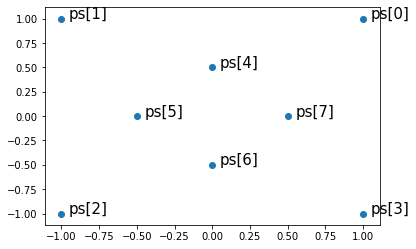

In [68]:
# __NOT_RENDER_SOURCE__
reload(drawer)
fig1 = drawer.fig()
fig1.add_points(ps)
for i in range(len(ps)):
    fig1.add_text(ps[i], f"ps[{i}]")
fig1.draw()

### 重心を計算する

まずは、与えられた点の重心を計算する

In [69]:
def calc_center(ps):
    return np.mean(ps, axis=0)
center = calc_center(ps)

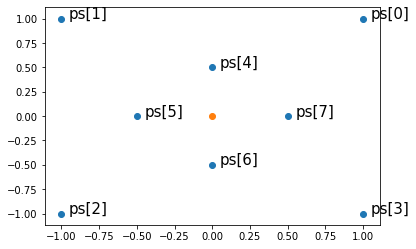

In [70]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(ps)
for i in range(len(ps)):
    fig1.add_text(ps[i], f"ps[{i}]")
fig1.add_point(*center)
fig1.draw()

### 重心からの角度を計算する

「`ps`の各点と重心を結ぶ線」と「x軸に平行な線」の角度を計算する

In [71]:
def normalize(ps):
    return (ps.T / np.linalg.norm(ps, axis=1)).T

In [72]:
def calc_angle(p):
    p2 = normalize(p)
    ac = np.arccos(p2[:,0])
    ac[np.where(p2[:,1] < 0)] *= -1
    ac[np.where(p2[:,1] < 0)] += 2*np.pi
    return ac * 180 / np.pi

In [73]:
ps2 = ps - center
ps3 = normalize(ps2)
angles = calc_angle(ps3)
print("angles=", angles)

angles= [ 45. 135. 225. 315.  90. 180. 270.   0.]


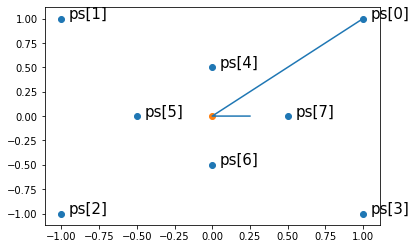

In [57]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(ps)
for i in range(len(ps)):
    fig1.add_text(ps[i], f"ps[{i}]")
fig1.add_point(*center)
fig1.add_lines(ps[0], center, [0.25, 0])
fig1.draw()

### 重心からの角度の小さい順に並べる

In [10]:
sorted = ps[np.argsort(angles)]

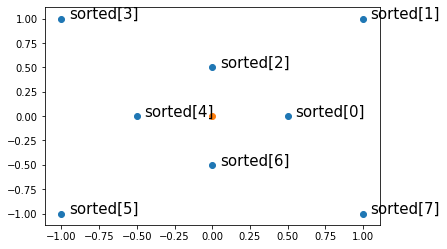

In [58]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(sorted)
for i in range(len(sorted)):
    fig1.add_text(sorted[i], f"sorted[{i}]")
fig1.add_point(*center)
fig1.draw()

### 左下の点が先頭に来るように、配列を回転

In [12]:
ll = sorted[0]
start = 0
for i in range(1, len(sorted)):
    cur = sorted[i]
    if (cur[0] < ll[0]) or (cur[0] == ll[0] and cur[1] < ll[1]):
        ll = cur
        start = i
rotated = np.vstack([sorted[start:], sorted[:start]])

左下の点 = (x,y)座標の辞書式順序で最小の点は、必ず凸包に含まれることに注意する。つまり、上のコードで`rotated[0]`は、必ず答えに含まれる

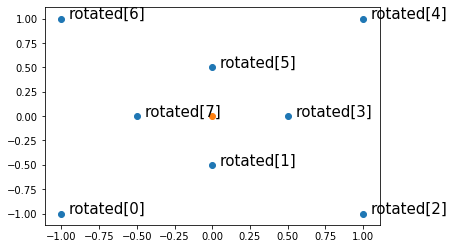

In [59]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(rotated)
for i in range(len(rotated)):
    fig1.add_text(rotated[i], f"rotated[{i}]")
fig1.add_point(*center)
fig1.draw()

`rotated`の点を、0から順にたどり、線でつないでみる。

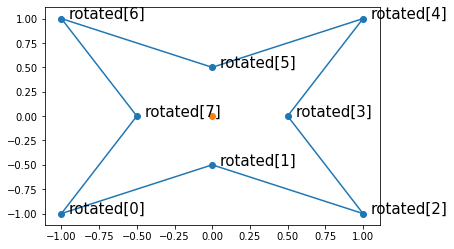

In [60]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(rotated)
for i in range(len(rotated)):
    fig1.add_text(rotated[i], f"rotated[{i}]")
fig1.add_point(*center)
fig1.add_lines(*np.vstack([rotated, rotated[:1]]))
fig1.draw()

今、上の多角形の辺の上を、0番目の頂点から順番に歩く旅人を想像してみる。
この旅人は、各頂点にたどり着くと、次の頂点に向かって進行方向を変更する。このとき、
この多角形の凹んでいる頂点の上では進行方向を時計回りに回転させていることが分かる。

もう少し数学的に言うと、`rotated[n+1]`が直線`rotated[n-1]rotated[n]`の右側にある場合、
旅人は、`rotated[n]`において進行方向を時計回りに回転させる。そして、そのような点は、この多角形の凹んでいるところに対応する。

つまり、旅人の軌跡をシミュレートしたときに、進行方向が時計回りに変わる点は、凸包の頂点ではないとして除外できる。

In [15]:
def on_left(a, b, c):
    """
    Parameters
    ----------
    a, b, c: np.ndarray of shape (1, 2).
    
    Returns
    -------
    ret: bool.
    Standing on point a, watching point b, if c is left of the line ab, returned value is True.
    """
    mat = np.ones((3,3))
    mat[:,:2] = [a,b,c]
    return np.linalg.det(mat) > 0

In [16]:
answer = []
n = len(rotated)
for i in range(n):
    if on_left(rotated[i-1], rotated[i], rotated[(i+1)%n]):
        answer.append(rotated[i])
answer = np.array(answer)
print(answer)

[[-1. -1.]
 [ 1. -1.]
 [ 1.  1.]
 [-1.  1.]]


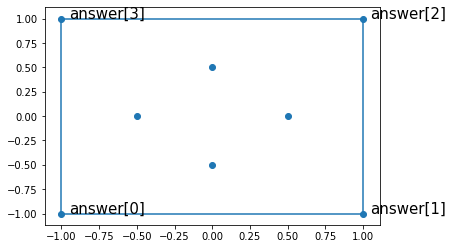

In [61]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(rotated)
for i in range(len(answer)):
    fig1.add_text(answer[i], f"answer[{i}]")
fig1.add_lines(*np.vstack([np.array(answer), answer[0]]))
fig1.draw()

この例では、上の手順によって正しく凸包を得ることができるが、実は、まだ少し足らない部分がある。

`rotated`が下のような値になる場合を考える

In [18]:
rotated2 = np.array([
    [-1, -1],
    [0, -0.7],
    [0.3, 0],
    [1, -1],
    [1, 1],
    [-1, 1]
])

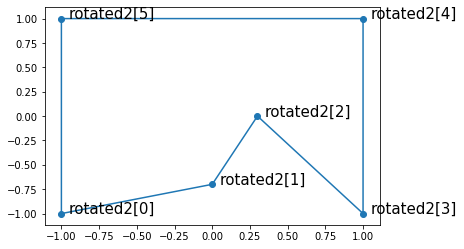

In [62]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(rotated2)
for i in range(len(rotated2)):
    fig1.add_text(rotated2[i], f"rotated2[{i}]")
fig1.add_lines(*np.vstack([rotated2, rotated2[:1]]))
fig1.draw()

これに対して、先ほどと全く同じアルゴリズムで計算してみる。

In [20]:
answer2 = []
n = len(rotated2)
for i in range(n):
    if on_left(rotated2[i-1], rotated2[i], rotated2[(i+1)%n]):
        answer2.append(rotated2[i])
answer2 = np.array(answer2)
print(answer2)

[[-1.  -1. ]
 [ 0.  -0.7]
 [ 1.  -1. ]
 [ 1.   1. ]
 [-1.   1. ]]


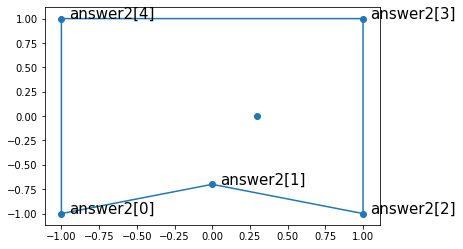

In [63]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(rotated2)
for i in range(len(answer2)):
    fig1.add_text(answer2[i], f"answer2[{i}]")
fig1.add_lines(*np.vstack([np.array(answer2), answer2[0]]))
fig1.draw()

結果は、上の図のとおり上手く行かない。

これは、`rotated2[0] -> rotated2[1] -> rotated2[2]`とたどったときには、`rotated[1]`での回転方向は反時計回りだったが、`rotated2[2]`が削除されたことで、ルートが`rotated2[0] -> rotated2[1] -> rotated2[3]`と変化し、それに伴い`rotated2[1]`での回転方向が変わったためである。

つまり、頂点nを削除することで直前の頂点n-1で回転方向が変わる可能性があることを考慮し、頂点nの削除後に、頂点n-1の回転方向が時計回りに変化した場合は頂点n-1も削除する（それによってさらに前の頂点n-2の方向が変わったらn-2も削除する・・と必要な限り続く）というケアをしなければならない。

これは、少しややこしいが、以下のようなコードで計算することができる。

In [26]:
answer3 = [rotated2[0], rotated2[1]]
n = len(rotated2)
for i in range(2, n+1):
    answer3.append(rotated2[i%n])
    while len(answer3) >= 3 and not on_left(answer3[-3], answer3[-2], answer3[-1]):
        answer3 = answer3[:-2] + answer3[-1:]
answer3 = answer3[:-1]
print(answer3)

[array([-1., -1.]), array([ 1., -1.]), array([1., 1.]), array([-1.,  1.])]


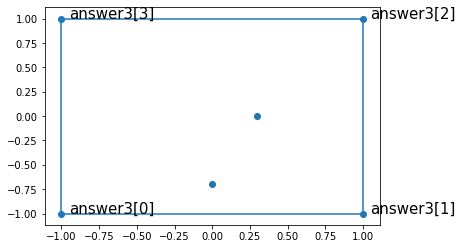

In [64]:
# __NOT_RENDER_SOURCE__

reload(drawer)
fig1 = drawer.fig()
fig1.add_points(rotated2)
for i in range(len(answer3)):
    fig1.add_text(answer3[i], f"answer3[{i}]")
fig1.add_lines(*np.vstack([np.array(answer3), answer3[0]]))
fig1.draw()

## 凸包を計算する関数

以上をまとめると、下のような関数を得る。

In [48]:
def graham_scan(ps):
    """
    Parameters
    ----------
    ps: np.ndarray of shape (n, 2)
    
    Returns
    -------
    convex hull: np.ndarray of shape (m, 2), where m <= n.
    """
    center = calc_center(ps)
    ps2 = ps - center
    angle = calc_angle(ps2)
    ps3 = ps[np.argsort(angle)]
    if len(ps) <= 3:
        return ps3
    start = 0
    p0 = ps3[0]
    n = len(ps)
    for i in range(1, n):
        cur = ps3[i]
        if (cur[0] < p0[0]) or \
            (cur[0] == p0[0] and cur[1] < p0[1]):
            p0 = cur
            start = i
    ps4 = np.vstack([ps3[start:], ps3[:start], [ps3[start]]])
    ret = []
    ret.append(ps4[0])
    ret.append(ps4[1])
    for p in ps4[2:]:
        ret.append(p)
        while len(ret) >= 3 and not on_left(ret[-3], ret[-2], ret[-1]):
            ret = ret[:-2] + ret[-1:]
    return np.array(ret[:-1])

## 乱数で実験してみる

In [53]:
ps3 = np.random.normal(0, 1, 200).reshape((-1,2))
gs = graham_scan(ps3)
gs

array([[-2.14713459, -0.56659542],
       [-1.17952482, -1.58090278],
       [-0.51283712, -1.95509565],
       [ 0.31022253, -2.19403907],
       [ 2.50506891, -1.66075892],
       [ 1.72618408,  2.05005001],
       [ 0.15580596,  2.35122882],
       [ 0.04697222,  2.30288457],
       [-1.8750918 ,  0.98333792]])

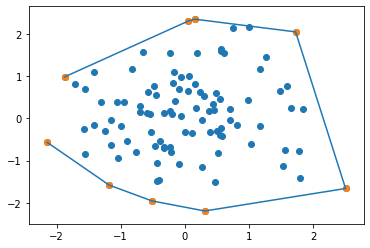

In [65]:
# __NOT_RENDER_SOURCE__

plt.scatter(ps3[:,0], ps3[:,1])
plt.scatter(gs[:,0], gs[:,1])
plt.plot(gs[:,0], gs[:,1])